# Quick start

PHIDL allows you to create complex designs from simple shapes, and can output the result as GDSII files. The basic element of PHIDL is the `Device`, which can be thought of as a blank area to which you can add polygon shapes. The polygon shapes can also have `Port`s on them--these allow you to snap shapes together like Lego blocks. You can either hand-design your own polygon shapes, or there is a large library of pre-existing shapes you can use as well.

Let's start by trying to make a rectangle shape with ports on either end.

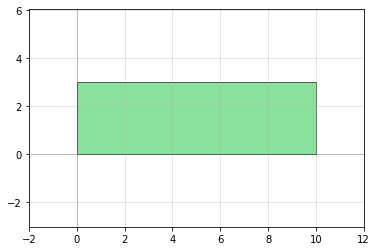

In [5]:
import numpy as np
from phidl import quickplot as qp
from phidl import Device
import phidl.geometry as pg


# First we create a blank device `R` (R can be thought of as a blank 
# GDS cell with some special features). Note that when we
# make a Device, we usually assign it a variable name with a capital letter
R = Device('myrectangle')

# Next, let's make a list of points representing the points of the rectangle
# for a given width and height
width = 10
height = 3
points =  [(0, 0), (width, 0), (width, height), (0, height)]

# Now we turn these points into a polygon shape using add_polygon()
R.add_polygon(points)

# Let's use the built-in "quickplot" function to display the polygon we put in D
qp(R)

Next, let's add `Port`s to the rectangle which will allow us to connect it to other shapes easily

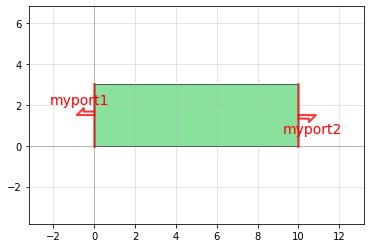

In [6]:
# Ports are defined by their width, midpoint, and the direction (orientation) they're facing
# They also must have a name -- this is usually a string or an integer
R.add_port(name = 'myport1', midpoint = [0,height/2], width = height, orientation = 180)
R.add_port(name = 'myport2', midpoint = [width,height/2], width = height, orientation = 0)

# The ports will show up when we quickplot() our shape
qp(R) # quickplot it!

Our Device looks good! Since this Device is finished, let's create a new (blank) Device and add several shapes to it. Specifically, we will add an arc from the built-in geometry library and two copies of our rectangle Device.  We'll then then connect one rectangle to either end of the arc.

This process involves adding "references".  These references allow you to create a Device shape once, then reuse it many times in other Devices. 

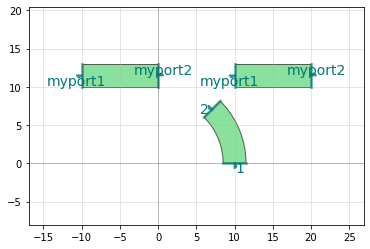

In [11]:
# Create a blank Device
E = Device('arc_with_rectangles')

# Also create an arc from the built-in library
A = pg.arc(width = 3)

# Add a "reference" of the arc to our blank Device
arc_ref = E.add_ref(A)

# Also add two references to our rectangle Device
rect_ref1 = E.add_ref(R)
rect_ref2 = E.add_ref(R)

# Move the shapes around a little
rect_ref1.move([10,10])
rect_ref2.move([-10,10])

qp(E)

Now we can see we have added 3 shapes to our Device "E". We see that our rectangle Device has been referenced twice, and each of the references has `Port`s on it. We can also see that the arc has `Port`s on it as well with the names 1 and 2.

Next, let's snap everything together like Lego blocks using the `connect()` command.